In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.2


In [2]:
# Random seed for reproducibility
seed = 16

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
dataset_path = os.path.join('../input/anndlhw2/Training.csv')

In [4]:
X = np.genfromtxt('../input/anndlhw2/Training.csv',delimiter=',',skip_header=True)

In [5]:
# Pre-processing

X_max = X.max(axis=0)
X_min = X.min(axis=0)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)

X_scaled = (X-X_min)/(X_max-X_min)

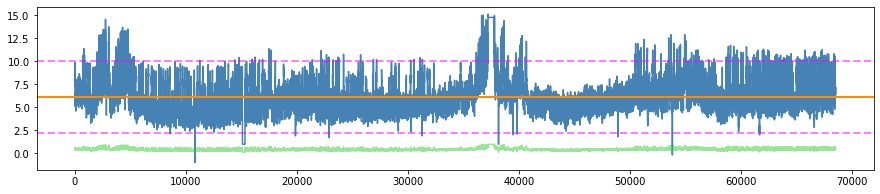

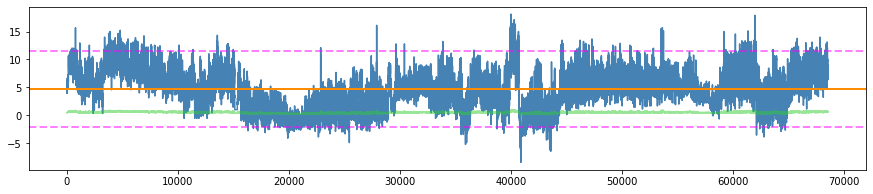

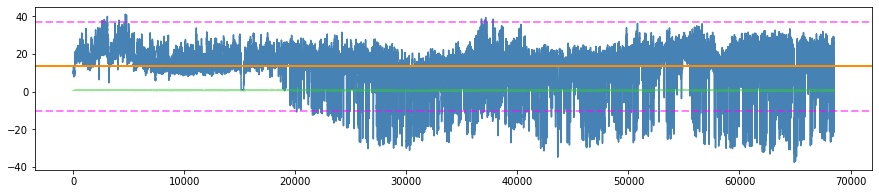

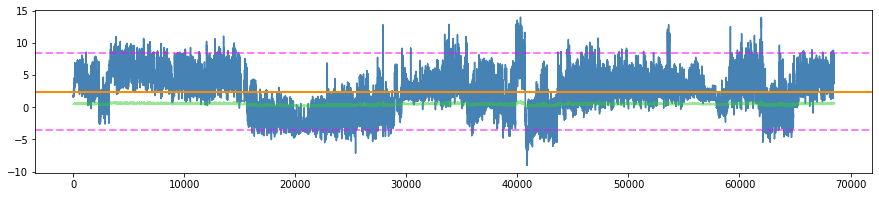

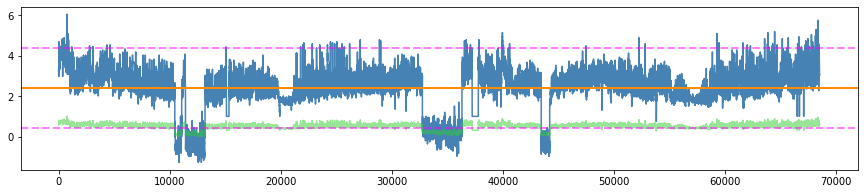

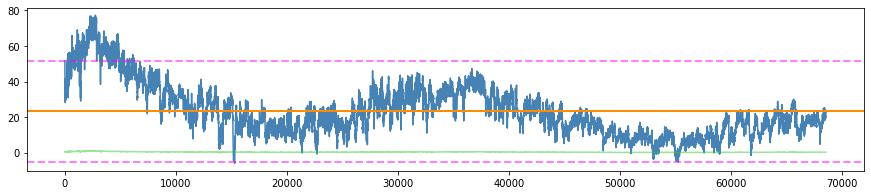

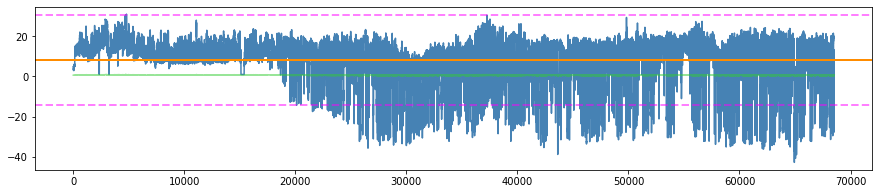

In [6]:
for i in range(X.shape[-1]):
    plt.figure(figsize=(15,3))
    plt.plot(X[:,i],color='steelblue')
    plt.plot(X_scaled[:,i],color='limegreen',alpha=.5)
    plt.axhline(y=X_mean[i],color='darkorange',linewidth=2)
    plt.axhline(y=X_mean[i]+2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)
    plt.axhline(y=X_mean[i]-2*X_std[i],color='magenta',alpha=.5,linestyle='--',linewidth=2)

In [7]:
# generate X, y
def extract_sequences(array,sequence_length = 200,stride=1,shuffle=True,seed=1):
   
    X = []
    y = []
    for i in range(0,len(array),stride):
        if i+sequence_length < len(array):
            X.append(array[i:i+sequence_length])
            y.append(array[i+sequence_length])
    X = np.array(X)
    y = np.array(y)
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(X)
        np.random.seed(seed)
        np.random.shuffle(y)
    return X, y

In [8]:
sequence_length = 400
stride = 1
X_train, y_train = extract_sequences(X_scaled,sequence_length,stride)
input_shape = X_train.shape[1:]

In [9]:
input_shape = X_train.shape[1:]
epochs = 200
batch_size = 256

In [14]:
def build_lstm(input_shape,n_units):


    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LSTM(units=n_units, return_sequences=False,return_state=False)(input_layer)
    x = tfkl.Flatten()(x)
    
    output_layer = tfkl.Dense(7)(x)
    
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    
    return model

In [15]:
lstm_units=512
model = build_lstm(input_shape,lstm_units)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 400, 7)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1064960   
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 3591      
Total params: 1,068,551
Trainable params: 1,068,551
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(1e-3), metrics=['mae'])

history = model.fit(
    X_train,
    y_train,
    validation_split=.1,
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.5, min_lr=1e-5)
    ]
).history

2022-01-12 08:58:36.915001: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-01-12 08:58:38.864832: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


240/240 [==============================] - 41s 159ms/step - loss: 0.0088 - mae: 0.0522 - val_loss: 0.0017 - val_mae: 0.0283
Epoch 2/200
240/240 [==============================] - 38s 157ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0014 - val_mae: 0.0254
Epoch 3/200
240/240 [==============================] - 38s 157ms/step - loss: 0.0012 - mae: 0.0238 - val_loss: 0.0012 - val_mae: 0.0234
Epoch 4/200
240/240 [==============================] - 38s 157ms/step - loss: 0.0011 - mae: 0.0223 - val_loss: 0.0011 - val_mae: 0.0229
Epoch 5/200
240/240 [==============================] - 38s 157ms/step - loss: 0.0010 - mae: 0.0213 - val_loss: 9.8333e-04 - val_mae: 0.0203
Epoch 6/200
240/240 [==============================] - 38s 157ms/step - loss: 9.6045e-04 - mae: 0.0203 - val_loss: 0.0010 - val_mae: 0.0208
Epoch 7/200
240/240 [==============================] - 38s 157ms/step - loss: 9.2651e-04 - mae: 0.0199 - val_loss: 9.0298e-04 - val_mae: 0.0193
Epoch 8/200
240/240 [=======================

In [19]:
window = sequence_length
last_window = X_scaled[-window:]
last_window = np.expand_dims(last_window, axis=0)
pred = model.predict(last_window)
last_window.shape, pred.shape

((1, 400, 7), (1, 7))

In [20]:
future_window = 1152

pred = np.array([])
X_temp = last_window
for t in range(future_window):
    pred_temp = model.predict(X_temp)
    pred_temp = np.expand_dims(pred_temp, axis=0)
    if(len(pred)==0):
        pred = pred_temp
    else:
        pred = np.concatenate((pred,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [21]:
pred_scaled = pred[0]*(X_max-X_min)+X_min

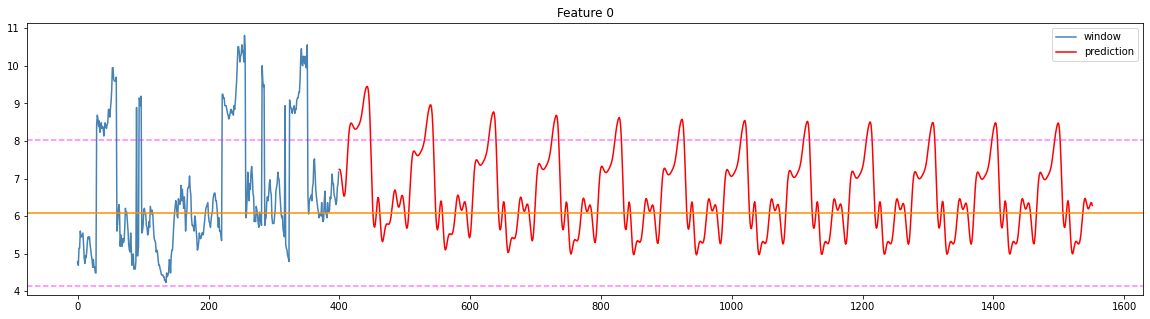

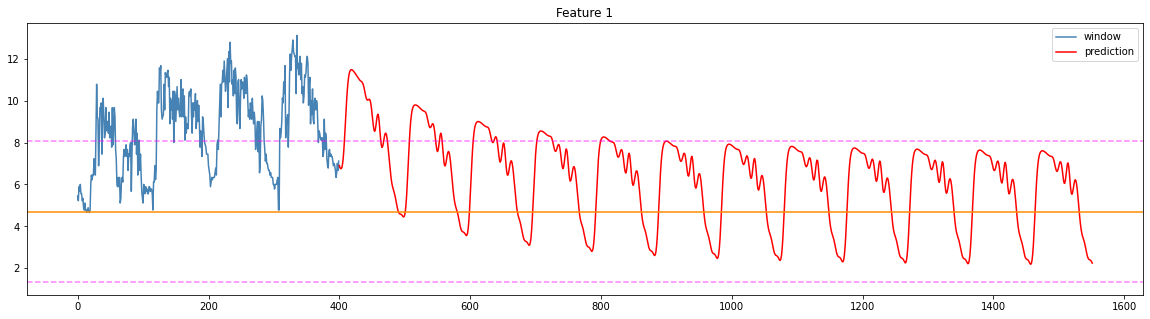

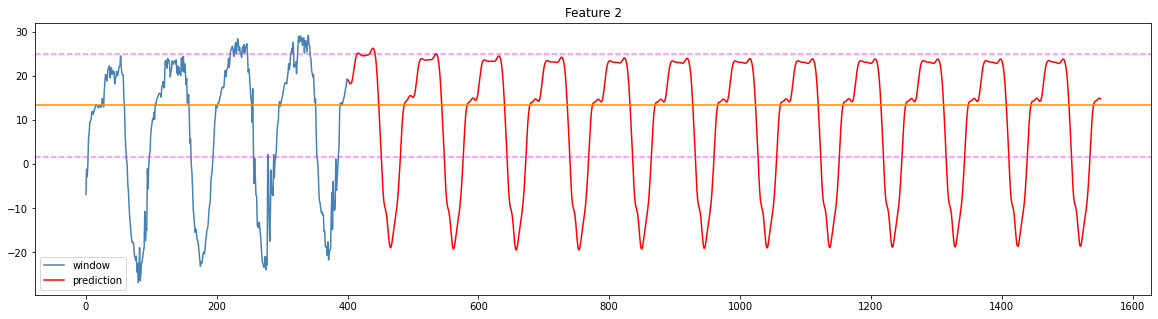

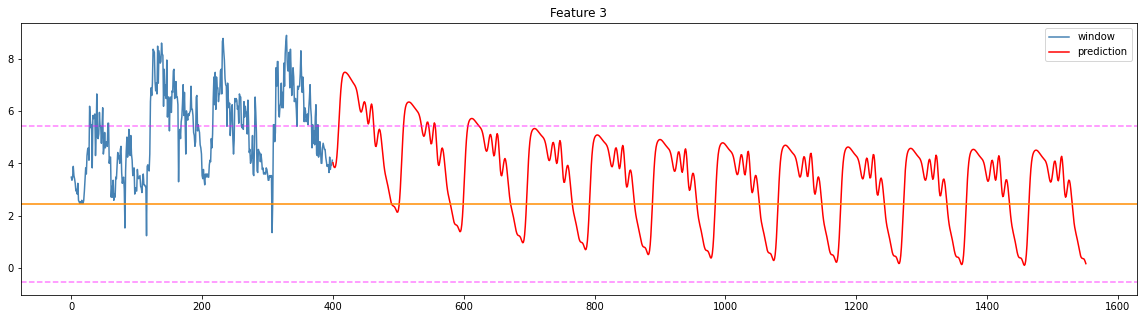

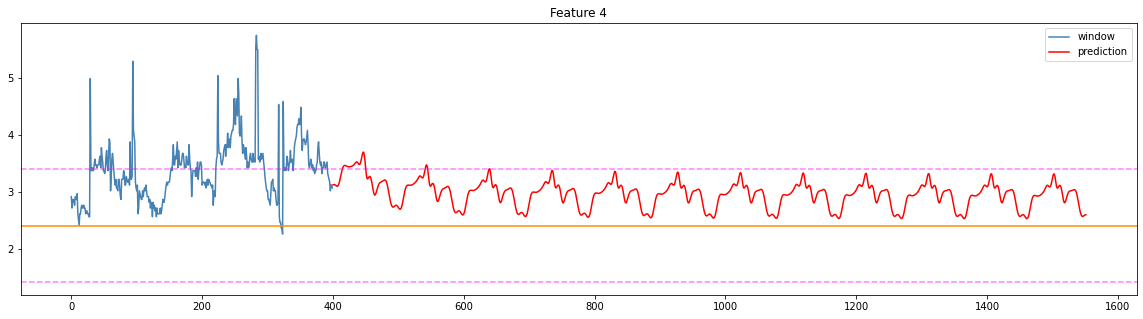

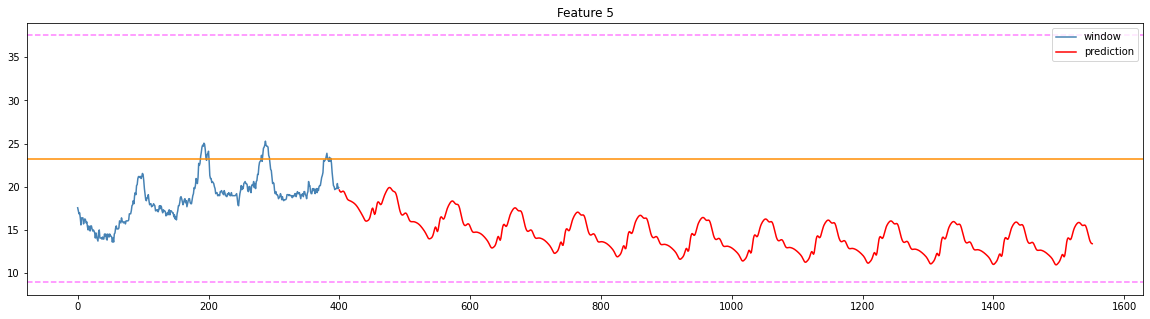

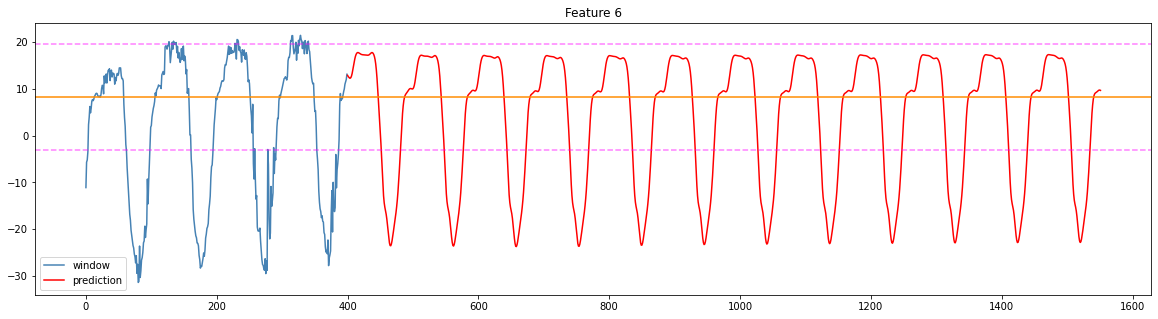

In [34]:
window = 400
future_window = 1152
for i in range(pred.shape[-1]):
    plt.figure(figsize=(20,5))
    plt.plot(range(window),X[-window:,i],color='steelblue',label='window')
    plt.plot(range(window,window+future_window),pred_scaled[:,i],color='red',label='prediction')
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.title('Feature ' + str(i))
    plt.legend()
    plt.savefig('bigplot'+str(i))

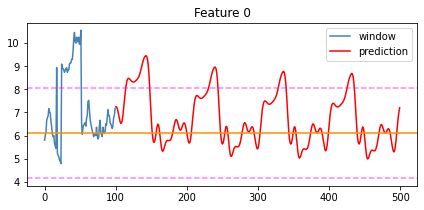

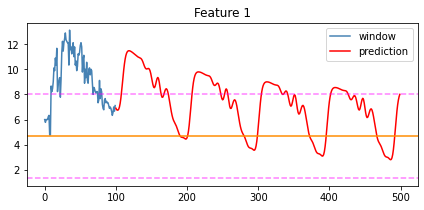

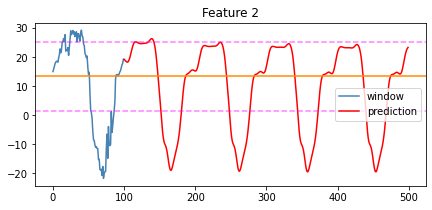

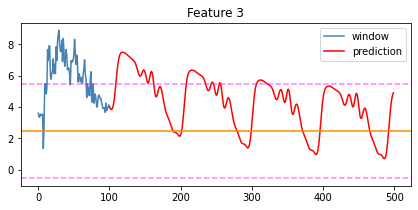

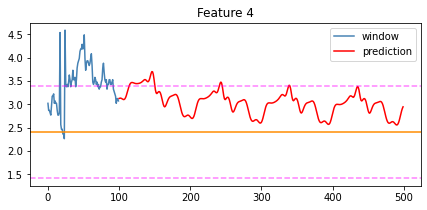

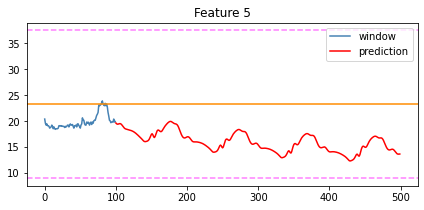

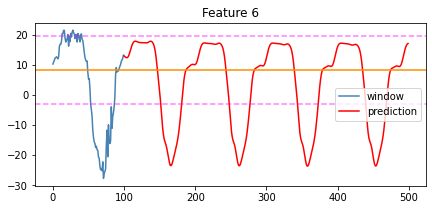

In [35]:
#PAPER PLOTS
window = 100
future_window = 400
for i in range(pred.shape[-1]):
    plt.figure(figsize=(7,3))
    plt.plot(range(window),X[-window:,i],color='steelblue',label='window')
    plt.plot(range(window,window+future_window),pred_scaled[:future_window,i],color='red',label='prediction')
    plt.axhline(y=X_mean[i],color='darkorange',linestyle='-')
    plt.axhline(y=X_mean[i]+X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.axhline(y=X_mean[i]-X_std[i],color='magenta',linestyle='--',alpha=.5)
    plt.title('Feature ' + str(i))
    plt.legend()
    plt.savefig('tinyplot'+str(i))

In [ ]:
#for i in range(pred_scaled.shape[-1]):
#    plt.figure(figsize=(20,5))
#    plt.plot(range(window),train_scaled[-window:,i])
#    plt.plot(range(window,window+future_window),val_scaled[:future_window,i])
#    plt.plot(range(window,window+future_window),pred[0,:,i])


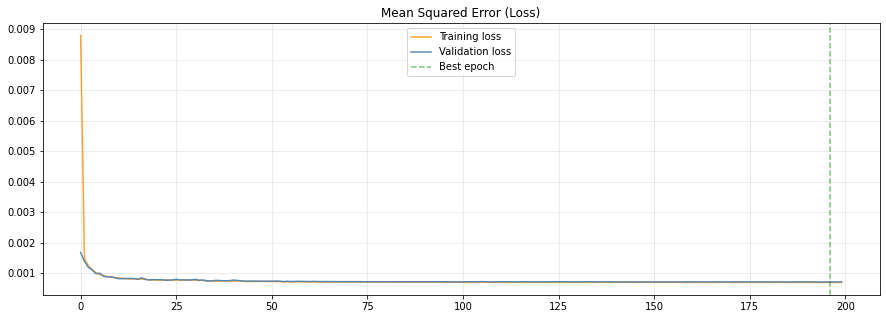

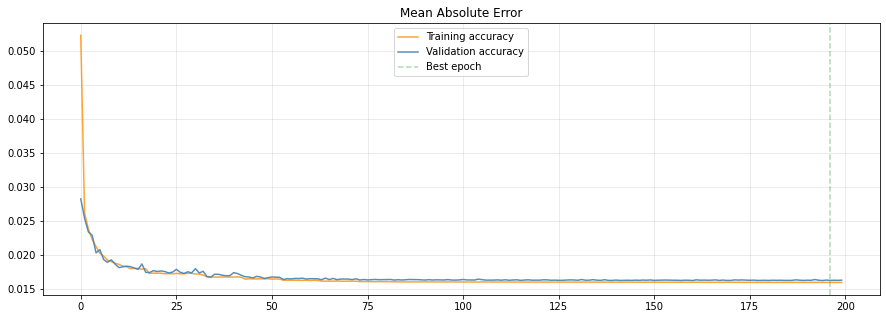

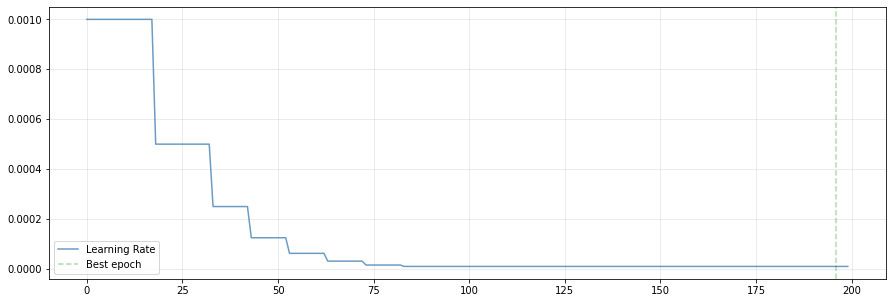

In [24]:
best_epoch = np.argmin(history['val_loss'])
fig_size = (15,5)
plt.figure(figsize=fig_size)
plt.plot(history['loss'], label='Training loss', alpha=.8, color='darkorange')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.5, ls='--', color='green')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='darkorange')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=fig_size)
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.legend()
plt.grid(alpha=.3)
plt.show()

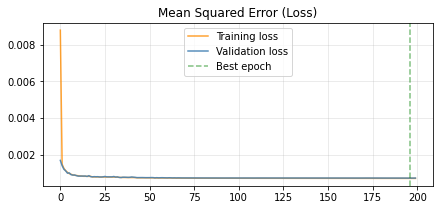

<Figure size 432x288 with 0 Axes>

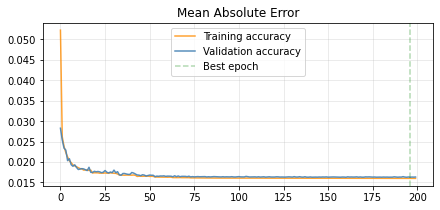

<Figure size 432x288 with 0 Axes>

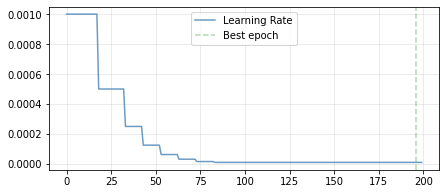

<Figure size 432x288 with 0 Axes>

In [27]:
#PAPER PLOTS
best_epoch = np.argmin(history['val_loss'])
fig_size = (7,3)
plt.figure(figsize=fig_size)
plt.plot(history['loss'], label='Training loss', alpha=.8, color='darkorange')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.5, ls='--', color='green')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()
plt.savefig("mse.png")

plt.figure(figsize=fig_size)
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='darkorange')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()
plt.savefig("mae.png")

plt.figure(figsize=fig_size)
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='steelblue')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='green')
plt.legend()
plt.grid(alpha=.3)
plt.show()
plt.savefig("lr.png")


In [25]:
model.save('model')
#model = tfk.models.load_model('model')
!zip -r model.zip model

2022-01-12 11:07:19.492578: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/keras_metadata.pb (deflated 86%)
  adding: model/assets/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 60%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 6%)
